# Lecture 5 Conversion Analysis on Web Design

## 1. Introduction
For this project, we will be analyzing the results of an A/B test run by an e-commerce website.  The final goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision

給電商公司做A/B test. 最終目標是想幫助公司改他們的介面。所以新介面對比原來的介面,公司想知道對於用戶的轉化是否有提升？ex:有多少用戶看到這個介面而下單購買了

## 2. Import data & data cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# 只記錄凌晨0-1點, 這一個小時所有用戶的活動紀錄
df=pd.read_excel('sample ab_data.xlsx')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,1
3,853541,28:03.1,treatment,new_page,1
4,864975,52:26.2,control,old_page,1


Get an overview of the dataset

In [3]:
# 這一個小時內有九萬個用戶
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Check if `group` aligns with `landing_page`

In [4]:
#先檢查有無systematic bias

In [5]:
#看看是否有些人被分成的treatment group,應該看的是new_page,但看成了old_page
# 有1965人
((df.group=='treatment') & (df.landing_page=='old_page')).sum()

np.int64(1965)

In [6]:
#看看是否有些人被分成的control group,應該看的是old_page,但看成了new_page
# 有1928人
((df.group=='control') & (df.landing_page=='new_page')).sum()

np.int64(1928)

In [7]:
# 把這兩個1900多人加在一起, 放在misaligned這個變量裡
# 並且讓整個df去扣掉misaligned這些錯誤
df['misaligned']=((df.group=='treatment') & (df.landing_page=='old_page')) | ((df.group=='control') & (df.landing_page=='new_page'))
df = df[-df['misaligned']]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
 5   misaligned    290585 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 13.6+ MB


Check unique users

In [9]:
# 檢查是否有些人被run了兩次
df.user_id.nunique()

290584

In [10]:
df['user_id'].value_counts().sort_values(ascending=False).head()
#得出773192這個人被run了兩次

,count
user_id,
773192,2
864975,1
679687,1
719014,1
909437,1


# make assumption:
## let's assume 樣本統計


In [11]:
# 773192這個客戶在37分的時候,用了new_page也轉化了.在55分的時候,用了new_page,卻沒有轉化
# 那到底用什麼去算？都可以
# 面試需要培養的習慣：make assumption. 遇到比較模糊的情況,就要先做假設
# 比如：假設1899最準確,那drop 2893
# 比如：假設lastest result最準確, 那drop 1899
# 做任何一個假設都可以,重點是要測試看看

In [12]:
# 1.檢查某個使用者是否重複出現. 這裡檢查user_id是773192
# 篩選出資料中 user_id == 773192 的所有列（row)

df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted,misaligned
1899,773192,37:58.8,treatment,new_page,1,False
2893,773192,55:59.6,treatment,new_page,0,False


In [13]:
# 2.將索引值為 1899 的那一列資料刪除（因為這一列是 user_id=773192 的其中一筆重複資料
# 比如：drop 1899

df.drop(1899, axis = 0,inplace = True)

In [14]:
# 3. 檢查還有沒有其他 user_id 重複出現超過一次
# 結果出來是沒有重複的user_id了. 所有使用者都只出現ㄧ次

df['user_id'].value_counts().sort_values(ascending=False).head()

,count
user_id,
817355,1
715931,1
851104,1
804228,1
661590,1


How many users in each group

In [15]:
# 很重要的一步：用groupby分組！用group這列去分組就會自動列出control group 和 treatment group. 而對應的是user_id.
# “以group去分組 並且和user_id相對應, 就能看到每個分組總共有多少使用者”

df[['user_id','group']].groupby('group').count()

,user_id
group,
control,145274
treatment,145310


In [16]:
# control組和treatment組總數差不多就行

Conversion rate in each group

In [17]:
# 比較 A 組和 B 組的轉換率（conversion rate），並看看每組有多少人參與
# 統計：user_id有多少人, coverted轉換率, mean
# 用mean是因為 mean = (1的個數 × 1 + 0的個數 × 0) ÷ 總數 = 轉換比例

# 把需要用到的列提取出來.計算轉換率＝需要總人數和轉換人數
# 用agg(),把user_id:count加總計數, converted:mean 轉換比例

df[['user_id','group','converted']].groupby('group').agg({'user_id':'count','converted':'mean'})

,user_id,converted
group,,
control,145274,0.120386
treatment,145310,0.125353


In [18]:
# 重點：這個只是樣本結果！！！！！！

# 樣本結果：treatment(新的)比control(舊的)轉換率高
# 但是不能因為樣本結果就說總體population就是新的比舊的好. 需要做假設檢驗

## 3. Analyze results

Let's assume that the new page does not have higher conversion rate than the old page at 5% Type I error. So the hypothesis woule be:

**null:** **$p_{new}$** - **$p_{old}$** <=0 (新的不如舊的)

**alternative:** **$p_{new}$** - **$p_{old}$** >0 (新的比較好)

In [19]:
# 因為有轉換率(rate), 所以用Binomial二項分佈
# 但是因為樣本數n足夠大, 以中央極限定理來看,二項分佈會趨近於正態分佈
# 所以用Z test計算, 再用Z score算p-value. 最後用p-value和alpha做對比

In [20]:
# 這裡要先製作一張清楚的轉化率比較表,快速比較兩組在A/B test測試中的表現

In [21]:
# Q:為什麼計算control/treatment group有多少人參與,用的是len()?而不是count()?sum()?
# A: len(): 計算總筆數(包含0和1). sum():只會加總1. count():只數“非NaN”的資料筆數

In [22]:
#1. 計算轉換人數 ＆ 參與人數

#1-1. 篩選出control組(old)和treatment組(new)的資料. 再把這些資料中conveted ==1的加總, 就是“有轉換的人數”

# df[df.group == 'control']：從整個 DataFrame 過濾出控制組（control）的人
# .converted：選出這群人中的 converted 欄位（這是一個只有 0 和 1 的欄位，1 表示成功轉換）

convert_old = df[df.group=='control'].converted.sum() # control group 中成功轉換的總人數
convert_new = df[df.group=='treatment'].converted.sum() # treatment group 中成功轉換的總人數

#1-2. control組(old)和treatment(new)組中, 各自的樣本數 = 各自的參與人數

# df[df.group=='control'].converted ＝ 控制組的 converted 欄位（包含 0 & 1）

n_old = len(df[df.group=='control'].converted) # control group中的converted轉換總人數
n_new= len(df[df.group=='treatment'].converted) # treatment group中的converted轉換總人數


convert_old, convert_new, n_old, n_new

(np.int64(17489), np.int64(18215), 145274, 145310)

In [23]:
#2. 建立轉換統計表的資料結構
#目的：列出control & treatment group的 Views總人數, Converts轉換總人數, Conversion % 轉換率

In [24]:
# Q: 為什麼要用dictionary?
# A: 因為結構清楚, Key直接對應到column name & row name. 容易被pd.DataFrame()轉換成表格

In [25]:

#2-1. 這是個Dictionary. 'Views'代表control控制組 和 test實驗組的觀看人數. Converts代表control控制組 和 test實驗組的轉換人數
conversion_dic = {'Views':{'Control':n_old,'Test':n_new},'Converts': {'Control':convert_old,'Test':convert_new}}

#2-2. 轉成表格、計算轉換率. 把字典轉換成Pandas表格(Dataframe)
conversion_table = pd.DataFrame(conversion_dic)

#2-3. 計算轉換率. 新增一列叫做轉換率,並附上公式
conversion_table['Conversion %'] = conversion_table['Converts'] / conversion_table['Views']

#2-4.轉換率格式化成百分比的字串. np.round(x,3) 代表保留三位小數, *100)+'%' 代表變成百分比字串
conversion_table['Conversion %'] = conversion_table['Conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%')
conversion_table

,Views,Converts,Conversion %
Control,145274,17489,12.0%
Test,145310,18215,12.5%


### 3.1 Z-test in our way

In [26]:
# 因為有轉化率,就代表他是binomial metric, 所以fellow binomical distribution二項分佈.
# 而另一個主要原因是樣本數足夠大,由於中心極限定理,二項分佈會逐漸趨近於正態分佈. 所以用Z-test

In [27]:
# 方法1: 套用公式算出z-value和p-value的步驟 (手動計算Z-test)

In [28]:
# Define 個 function放Ｚ-test的公式. 比較Control group和Treatement group的轉化率之間的差異

def z_test(p1,p0,n1,n0):
    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(p*(1-p)*(1/n1 + 1/n0))

In [29]:
p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [30]:
# 最後得出Z-value
z_value = z_test(p1,p0,n1,n0)
z_value

np.float64(4.077481782861739)

In [31]:
# 通過查表 或 scipy.stats函數, 得出p-value

from scipy.stats import norm
p_value = 1- norm.cdf(z_value)

p_value

np.float64(2.276304781123617e-05)

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
<br>**$p_{new}$** - **$p_{old}$** >0, the new page has higher conversion rate than the old page

### 3.2 Z-test in Statsmodels

In [32]:
# 方法2: 運用 sm 這個直接調包,就能直接算出z_score, p_value (自動計算)
import statsmodels.api as sm

In [33]:
# 只需放入以下幾個參數. 1.新舊的轉換人數 2.新舊的樣本數
# 3. alternative statement備擇性假設Ha放的是什麼？p new - p old > 0 是大於. 所以放larger
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(np.float64(4.077481782861739), np.float64(2.276304781118429e-05))

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
<br>**$p_{new}$** - **$p_{old}$** >0, the new page has higher conversion rate than the old page

# bonus - > eda - line plot 2 color control vs treatment + t- test

## 1. 計算Z-test

In [34]:
# 計算Z-test

# Method 1: 套用公式 (手動計算Z-test)

convert_old = df[df.group=='control'].converted.sum() # control group 中成功轉換的總人數
convert_new = df[df.group=='treatment'].converted.sum()

n_old = len(df[df.group=='control'].converted) # control group中的converted轉換總人數
n_new= len(df[df.group=='treatment'].converted)

#  Define 個 function放Ｚ-test的公式. 比較Control group和Treatement group的轉化率之間的差異

def z_test(p1,p0,n1,n0):
    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(p*(1-p)*(1/n1 + 1/n0))


# 定義四個數值,套用公式得出Z值
p1 = convert_new / n_new  #treatment組的平均值(也是轉換率)
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

z_value = z_test(p1, p0, n1, n0)

# 計算p-value

from scipy.stats import norm
p_value = 1 - norm.cdf(z_value)

print("Z-test:", z_value)
print("P-value:", p_value)

# 4. 比較p-value 和 alpha

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Z-test: 4.077481782861739
P-value: 2.276304781123617e-05
Reject null hypothesis


## 2. 計算T-test


In [35]:
# 方法1: 套用公式算出t-value和p-value的步驟 (手動計算Ｔ-test)

In [36]:
def t_test(p1, p0, n1, n0):
    # 各組的樣本變異數（Bernoulli 分布的近似變異數）
    s1_squared = p1 * (1 - p1)
    s0_squared = p0 * (1 - p0)

    # t 值計算
    delta = p1 - p0
    se = np.sqrt(s1_squared / n1 + s0_squared / n0)
    return delta / se

In [37]:
t_value = t_test(p1, p0, n1, n0)
print("T-value:", t_value)

from scipy.stats import t
p_value = 1 - t.cdf(t_value, df=n1+n0-2)
print("P-value:", p_value)

# 比較p-value 和 alpha

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

T-value: 4.077607214890113
P-value: 2.2756824421765742e-05
Reject null hypothesis


In [38]:
# Method2. 調包 (自動計算)

In [39]:
from statsmodels.stats.weightstats import ttest_ind

In [40]:
# 定義數值：兩組的原始資料
# 篩選出新舊版本的 converted 欄位（每筆是 0 或 1）
convert_old = df[df.group=='control']['converted']
convert_new = df[df.group=='treatment']['converted']

t_stat, p_value, dfree = ttest_ind(convert_new, convert_old, alternative='larger')

print("T-score:", t_stat)
print("P-value:", p_value)

# 比較p-value 和 alpha

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

T-score: 4.077584402638075
P-value: 2.275905649109748e-05
Reject null hypothesis


## 3. EDA: Line Plot
* x = timestamp (00:00-01:00)
* y = converted
* hue = control group & treatment group

### 將timestamp這一個小時分成60份(60個mins)
* 只提取timestamp的前兩位(mins的部分), 以mins去groupby control group & treatment group.
* 計算轉化率
* 畫圖

In [41]:
# 1-1. 把timestamp這列轉成string. 確保timestamp這一列是字串格式
df['timestamp'] = df['timestamp'].astype(str)

# 1-2. 新增一列"minute",直接提取前兩位,表示“分鐘”.就是01~59分鐘
df['minute'] = df['timestamp'].str[:2]

# 1-3. 再把"minute"這一列轉成數字, 是為了方便排序和畫圖
df['minute'] = df['minute'].astype(int)
df

,user_id,timestamp,group,landing_page,converted,misaligned,minute
0,851104,11:48.6,control,old_page,0,False,11
1,804228,01:45.2,control,old_page,0,False,1
2,661590,55:06.2,treatment,new_page,1,False,55
3,853541,28:03.1,treatment,new_page,1,False,28
4,864975,52:26.2,control,old_page,1,False,52
...,...,...,...,...,...,...,...
294473,751197,28:38.6,control,old_page,0,False,28
294474,945152,51:57.1,control,old_page,0,False,51
294475,734608,45:03.4,control,old_page,0,False,45
294476,697314,20:29.0,control,old_page,0,False,20


In [42]:
# 2. 建立轉換統計表的資料結構. 特點是用 "minute" + "group"去區分的. 每一組是：某一分鐘、某一組(control/treatment)
# 每組算出：有多少人看到了 ＆ 有多少人轉換了
# groupby要用'minute' & 'group'這列區分兩組.把control group & treatment group 的 Views總人數, Converts轉換總人數, Conversion % 轉換率

In [43]:
# Q: 為什麼不需要自己先算？
# A: 因為.groupby().agg()幫你從資料中 分組＋計算. 是對應著每一組做指定的聚合應算. 前面的dictionary是因為是計算總體, 所以需要總體人數整理匯總之後再做成表

In [44]:
# Q: minute_group_df['conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%')出現了很長的轉換率,要怎麼修改到小數點後一位？
# A: 用f-string格式化

In [45]:
# 2-1. 重點：針對每個minute去和兩組group的結合 & 聚合這段時間有多少人觀看 ＆聚合幾個人轉換了
minute_group_df = df.groupby(['minute', 'group']).agg({
    'user_id': 'count',         # 幾個人看到（觀看人數）
    'converted': 'sum'          # 幾個人轉換了（converted=1 的人數）
}).reset_index()

# 2-2. 改個列名, 方便之後讀取
minute_group_df.rename(columns={'user_id': 'views', 'converted': 'converts'}, inplace=True)


# 2-3. 計算轉換率 ＝ converts / view
minute_group_df['conversion_rate']= minute_group_df['converts'] / minute_group_df['views']


# 2-4. 轉換率格式化成百分比的字串. np.round(x,3) 代表保留三位小數, *100)+'%' 代表變成百分比字串

minute_group_df['conversion %'] = minute_group_df['conversion_rate'].apply(lambda x: f"{x*100:.1f}%")

minute_group_df
# 得出結果是每分鐘、每組, 都有自己的觀察數量和轉換數

,minute,group,views,converts,conversion_rate,conversion %
0,0,control,2456,292,0.118893,11.9%
1,0,treatment,2371,290,0.122311,12.2%
2,1,control,2283,294,0.128778,12.9%
3,1,treatment,2404,281,0.116889,11.7%
4,2,control,2372,284,0.119730,12.0%
...,...,...,...,...,...,...
115,57,treatment,2495,294,0.117836,11.8%
116,58,control,2418,290,0.119934,12.0%
117,58,treatment,2364,292,0.123519,12.4%
118,59,control,2423,292,0.120512,12.1%


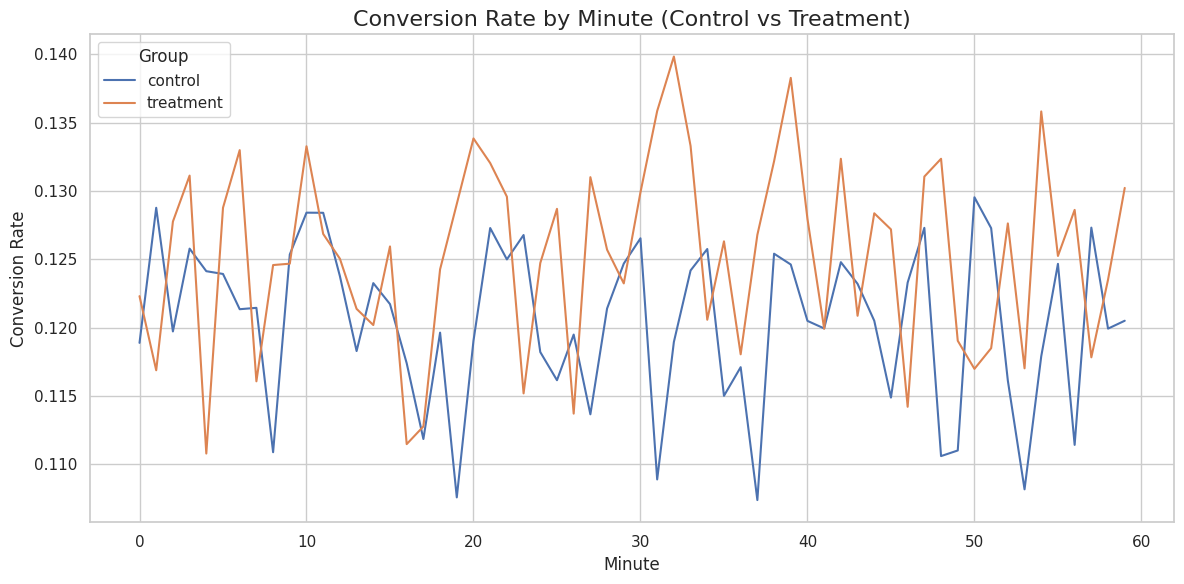

In [46]:
sns.set(style='whitegrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=minute_group_df, x='minute', y='conversion_rate', hue='group')

plt.title('Conversion Rate by Minute (Control vs Treatment)', fontsize=16)
plt.xlabel('Minute', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.legend(title='Group')  # 調整圖例標題
plt.tight_layout()

plt.show()

In [47]:
# Q:from scipy.stats impoty norm 和 from scipy.stats import ttest_ind這兩個有什麼不一樣？
# A: norm 是用來查 Z 分布 (常態分布）的機率；ttest_ind 是用來做 T 檢定（小樣本或樣本變異數未知的情況)

# norm 是在「查 Z 分布機率」＝ 自己有 z-score 要查機率
# ttest_ind 是在「比較兩組平均值有沒有顯著差異」＝ 自動幫你做 T 檢定